In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

from tabpfn import TabPFNClassifier
from sklearn import preprocessing
from sklearn import impute

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
imputer = impute.SimpleImputer(strategy="median")
imputer.fit(train[input_cols])
train[input_cols] = imputer.transform(train[input_cols])
test[input_cols] = imputer.transform(test[input_cols])

#scaler = preprocessing.MaxAbsScaler()
#scaler.fit(train[input_cols])
#train[input_cols] = scaler.transform(train[input_cols])
#test[input_cols] = scaler.transform(test[input_cols])

In [4]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 10

10


***
## training

In [5]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2

#def balanced_logloss(y_pred: np.ndarray, data: lgb.Dataset):
#    y_true = data.get_label()
#    return 'balanced_logloss', balanced_logloss_(y_pred, y_true), False 

In [6]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [7]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
        scale_probs=False,
    ):

    metrics = list()
    model_params = dict(model_params)

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            clf = TabPFNClassifier(**model_params)
            clf.fit(
                train_df[input_cols].values, 
                train_df["Class"].values, 
                overwrite_warning=True
            )
            y_pred = clf.predict_proba(valid_df[input_cols].values)

            if scale_probs:
                y_pred = (y_pred / np.sum(y_pred, axis=0))
                y_pred = (y_pred / np.sum(y_pred, axis=1, keepdims=1))

            metrics.append( balanced_logloss_(y_pred[:,1], valid_df["Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    model_params = dict(
        N_ensemble_configurations = 2**trial.suggest_int("N_ensemble_configurations_exp", 2, 7),
        no_preprocess_mode = trial.suggest_categorical("no_preprocess_mode", [True, False]),
        multiclass_decoder = trial.suggest_categorical("multiclass_decoder", ["permutation", ""]),
        feature_shift_decoder = trial.suggest_categorical("feature_shift_decoder", [True, False]),
        scale_probs = trial.suggest_categorical("scale_probs", [True, False]),
    )
    scale_probs = model_params.pop("scale_probs")
    
    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
        scale_probs = scale_probs,
    )
    
    return metric_mean

In [8]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = dict(N_ensemble_configurations=4, ),
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False,
    scale_probs = True,
)

Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


CPU times: user 3min 20s, sys: 2.68 s, total: 3min 22s
Wall time: 1min 13s


(0.2655965460010707, 0.08868033645292092)

In [9]:
do_optimize = True

search_space = {
    'N_ensemble_configurations_exp': [2,3,4,5,6,7],
    'no_preprocess_mode': [True, False],
    "multiclass_decoder": ["permutation", ""],
    "feature_shift_decoder": [True, False],
    "scale_probs": [True, False],
}
study = optuna.create_study(
    study_name="iarc-tabpfn",
    direction='minimize',
    storage='sqlite:///iarc-tabpfn.db',
    load_if_exists=True,
    sampler=optuna.samplers.GridSampler(search_space),
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-07-01 05:56:19,674] Using an existing study with name 'iarc-tabpfn' instead of creating a new one.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:11:23,949] Trial 1 finished with value: 0.29698059997668513 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 1 with value: 0.29698059997668513.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:12:15,010] Trial 2 finished with value: 0.3917667228135668 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 1 with value: 0.29698059997668513.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:12:41,135] Trial 3 finished with value: 0.296654374432833 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 3 with value: 0.296654374432833.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:16:10,548] Trial 4 finished with value: 0.4173106653104265 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 3 with value: 0.296654374432833.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:17:57,788] Trial 5 finished with value: 0.39316987343286286 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 3 with value: 0.296654374432833.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:18:48,209] Trial 6 finished with value: 0.266102183644723 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 6 with value: 0.266102183644723.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:19:14,549] Trial 7 finished with value: 0.42738769622145967 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 6 with value: 0.266102183644723.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:20:49,869] Trial 8 finished with value: 0.30035139091130053 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 6 with value: 0.266102183644723.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:24:34,883] Trial 9 finished with value: 0.3937472782309041 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 6 with value: 0.266102183644723.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:32:10,613] Trial 10 finished with value: 0.2971904048926236 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 6 with value: 0.266102183644723.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:32:46,032] Trial 11 finished with value: 0.41871202892380305 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 6 with value: 0.266102183644723.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:33:12,384] Trial 12 finished with value: 0.42738769622145967 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 6 with value: 0.266102183644723.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:34:21,592] Trial 13 finished with value: 0.3793299562464483 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 6 with value: 0.266102183644723.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:35:31,167] Trial 14 finished with value: 0.2655965460010707 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 14 with value: 0.2655965460010707.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:36:06,618] Trial 15 finished with value: 0.41871202892380305 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 14 with value: 0.2655965460010707.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:37:00,668] Trial 16 finished with value: 0.41554067067923595 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 14 with value: 0.2655965460010707.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:37:51,652] Trial 17 finished with value: 0.3917667228135668 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 14 with value: 0.2655965460010707.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:38:27,815] Trial 18 finished with value: 0.41871202892380305 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 14 with value: 0.2655965460010707.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:46:18,642] Trial 19 finished with value: 0.39404615658826847 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 14 with value: 0.2655965460010707.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:46:54,383] Trial 20 finished with value: 0.29665182398207596 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 14 with value: 0.2655965460010707.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 06:48:03,447] Trial 21 finished with value: 0.2646769922995128 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:00:05,359] Trial 22 finished with value: 0.2989522041717339 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:00:55,830] Trial 23 finished with value: 0.266102183644723 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:01:22,258] Trial 24 finished with value: 0.42738769622145967 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:01:48,627] Trial 25 finished with value: 0.42738769622145967 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:09:14,839] Trial 26 finished with value: 0.2694428515510576 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:10:05,719] Trial 27 finished with value: 0.3917667228135668 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:17:15,979] Trial 28 finished with value: 0.4176273433624998 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:18:28,922] Trial 29 finished with value: 0.2646769922995128 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:19:05,228] Trial 30 finished with value: 0.29665182398207596 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:20:15,712] Trial 31 finished with value: 0.2646769922995128 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:20:41,689] Trial 32 finished with value: 0.296654374432833 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:27:55,033] Trial 33 finished with value: 0.2988060704435798 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:29:04,310] Trial 34 finished with value: 0.3793299562464483 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:29:40,115] Trial 35 finished with value: 0.41871202892380305 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:30:49,313] Trial 36 finished with value: 0.2646769922995128 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:31:43,493] Trial 37 finished with value: 0.2978977439139101 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:32:33,904] Trial 38 finished with value: 0.266102183644723 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:35:42,583] Trial 39 finished with value: 0.270388946699384 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:36:51,713] Trial 40 finished with value: 0.394878742113767 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 07:48:56,537] Trial 41 finished with value: 0.2989522041717339 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:03:17,953] Trial 42 finished with value: 0.39208342544076025 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:03:45,412] Trial 43 finished with value: 0.42738769622145967 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:04:21,595] Trial 44 finished with value: 0.29665182398207596 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:32:20,739] Trial 45 finished with value: 0.2665660189038611 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:33:30,004] Trial 46 finished with value: 0.3793299562464483 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:34:25,024] Trial 47 finished with value: 0.2990342687735702 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:35:01,212] Trial 48 finished with value: 0.29665182398207596 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:35:38,491] Trial 49 finished with value: 0.29665182398207596 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:36:47,999] Trial 50 finished with value: 0.3698314201341355 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:37:57,846] Trial 51 finished with value: 0.3793299562464483 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:52:13,603] Trial 52 finished with value: 0.37935349297146453 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:53:46,156] Trial 53 finished with value: 0.2961169036577141 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:54:36,762] Trial 54 finished with value: 0.266102183644723 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:57:46,485] Trial 55 finished with value: 0.37647782711514766 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 08:58:37,308] Trial 56 finished with value: 0.3917667228135668 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 09:21:53,248] Trial 57 finished with value: 0.41750128810886017 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 09:23:26,090] Trial 58 finished with value: 0.4146821036200878 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 09:30:39,400] Trial 59 finished with value: 0.4279995390485511 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 09:42:48,034] Trial 60 finished with value: 0.4280210569905654 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 09:43:25,397] Trial 61 finished with value: 0.41871202892380305 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 09:50:54,601] Trial 62 finished with value: 0.3787657670406087 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 09:52:42,021] Trial 63 finished with value: 0.26793315380962723 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 10:16:09,608] Trial 64 finished with value: 0.39225560472847454 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 10:17:00,521] Trial 65 finished with value: 0.266102183644723 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 10:31:03,285] Trial 66 finished with value: 0.41771174567248914 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 10:45:21,971] Trial 67 finished with value: 0.2666139366548366 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 10:48:16,825] Trial 68 finished with value: 0.29931616096650493 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:02:35,531] Trial 69 finished with value: 0.26884449311357017 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:03:01,770] Trial 70 finished with value: 0.296654374432833 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:03:28,422] Trial 71 finished with value: 0.296654374432833 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:30:58,640] Trial 72 finished with value: 0.3799949526200402 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:32:08,061] Trial 73 finished with value: 0.26934247153773794 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:33:55,662] Trial 74 finished with value: 0.3737367361197029 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:34:31,436] Trial 75 finished with value: 0.41871202892380305 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:41:56,779] Trial 76 finished with value: 0.2667171219952928 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:43:44,442] Trial 77 finished with value: 0.2665898008855305 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:46:42,852] Trial 78 finished with value: 0.43034652334778883 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:58:52,976] Trial 79 finished with value: 0.4280210569905654 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 11:59:19,386] Trial 80 finished with value: 0.296654374432833 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:00:11,624] Trial 81 finished with value: 0.3917667228135668 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:01:21,095] Trial 82 finished with value: 0.3793299562464483 and parameters: {'N_ensemble_configurations_exp': 5, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:02:15,705] Trial 83 finished with value: 0.42677676317878893 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:26:13,986] Trial 84 finished with value: 0.26906110008176876 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:27:05,996] Trial 85 finished with value: 0.266102183644723 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:28:17,191] Trial 86 finished with value: 0.2646769922995128 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:29:28,221] Trial 87 finished with value: 0.2646769922995128 and parameters: {'N_ensemble_configurations_exp': 2, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:30:39,044] Trial 88 finished with value: 0.3793299562464483 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:31:16,836] Trial 89 finished with value: 0.29665182398207596 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': False, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:31:43,908] Trial 90 finished with value: 0.42738769622145967 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:55:22,996] Trial 91 finished with value: 0.2972523641747772 and parameters: {'N_ensemble_configurations_exp': 7, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 12:56:58,806] Trial 92 finished with value: 0.42856823184568027 and parameters: {'N_ensemble_configurations_exp': 3, 'feature_shift_decoder': True, 'multiclass_decoder': '', 'no_preprocess_mode': True, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 13:00:00,194] Trial 93 finished with value: 0.296726682313197 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': True, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 13:03:16,301] Trial 94 finished with value: 0.2661235692600299 and parameters: {'N_ensemble_configurations_exp': 4, 'feature_shift_decoder': True, 'multiclass_decoder': 'permutation', 'no_preprocess_mode': False, 'scale_probs': True}. Best is trial 21 with value: 0.2646769922995128.


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


Loading model that can be used for inference only


Using a Transformer with 25.82 M parameters


[I 2023-07-01 13:04:08,371] Trial 95 finished with value: 0.3917667228135668 and parameters: {'N_ensemble_configurations_exp': 6, 'feature_shift_decoder': False, 'multiclass_decoder': '', 'no_preprocess_mode': False, 'scale_probs': False}. Best is trial 21 with value: 0.2646769922995128.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_N_ensemble_configurations_exp,params_feature_shift_decoder,params_multiclass_decoder,params_no_preprocess_mode,params_scale_probs,system_attrs_grid_id,system_attrs_search_space,state
31,31,0.264677,2023-07-01 07:19:05.409987,2023-07-01 07:20:15.692573,0 days 00:01:10.282586,5,False,permutation,False,True,58,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE
29,29,0.264677,2023-07-01 07:17:16.166755,2023-07-01 07:18:28.903713,0 days 00:01:12.736958,4,False,permutation,False,True,42,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE
87,87,0.264677,2023-07-01 12:28:17.376087,2023-07-01 12:29:28.202828,0 days 00:01:10.826741,2,False,permutation,False,True,10,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE
86,86,0.264677,2023-07-01 12:27:06.189086,2023-07-01 12:28:17.171292,0 days 00:01:10.982206,7,False,permutation,False,True,90,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE
21,21,0.264677,2023-07-01 06:46:54.560737,2023-07-01 06:48:03.427670,0 days 00:01:08.866933,3,False,permutation,False,True,26,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE
36,36,0.264677,2023-07-01 07:29:40.289611,2023-07-01 07:30:49.294919,0 days 00:01:09.005308,6,False,permutation,False,True,74,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE
14,14,0.265597,2023-07-01 06:34:21.762442,2023-07-01 06:35:31.148169,0 days 00:01:09.385727,2,True,permutation,False,True,2,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE
65,65,0.266102,2023-07-01 10:16:09.796625,2023-07-01 10:17:00.501528,0 days 00:00:50.704903,4,False,,False,True,46,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE
54,54,0.266102,2023-07-01 08:53:46.336089,2023-07-01 08:54:36.742089,0 days 00:00:50.406000,7,False,,False,True,94,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE
23,23,0.266102,2023-07-01 07:00:05.536160,2023-07-01 07:00:55.810534,0 days 00:00:50.274374,2,False,,False,True,14,"{'N_ensemble_configurations_exp': [2, 3, 4, 5,...",COMPLETE


/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/kaleido/scopes/base.py:188: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



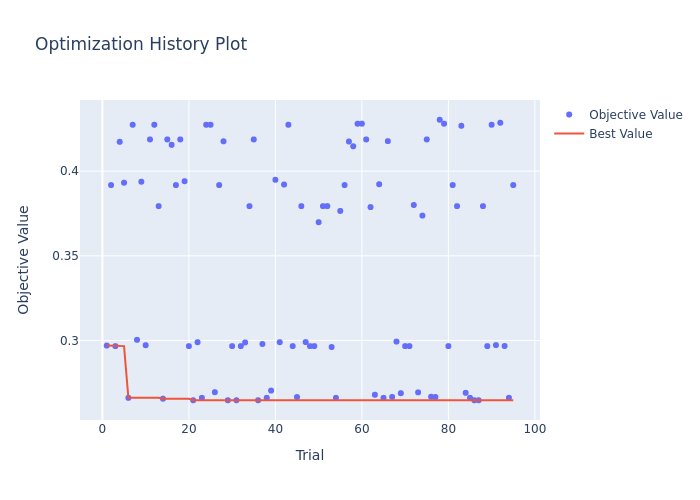

In [11]:
plot_optimization_history(study)

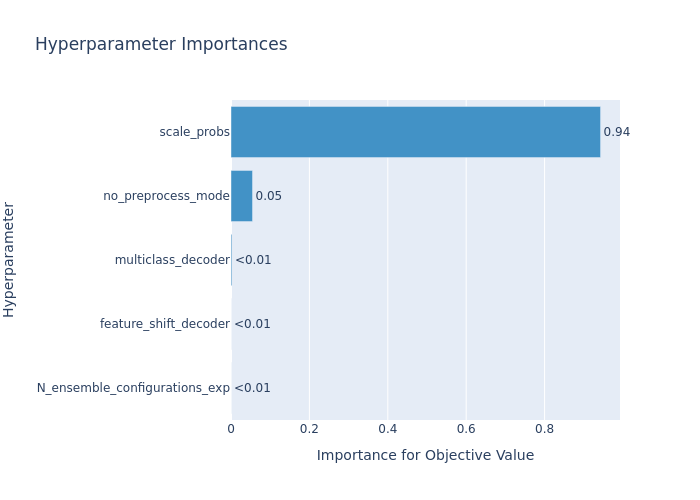

In [12]:
plot_param_importances(study)

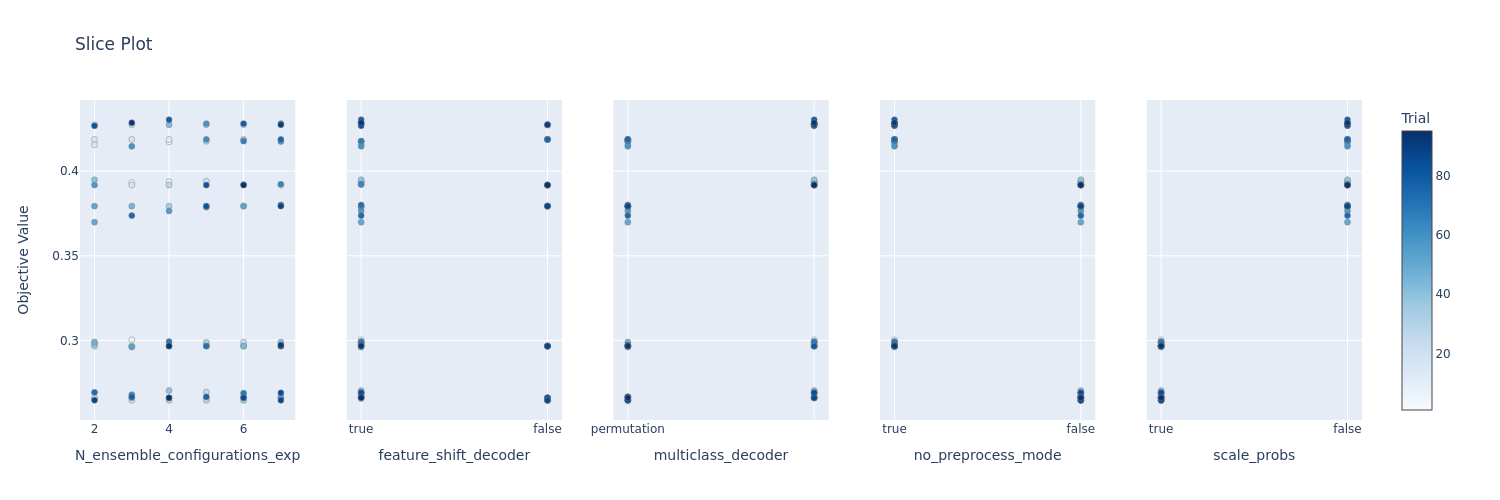

In [13]:
plot_slice(study)

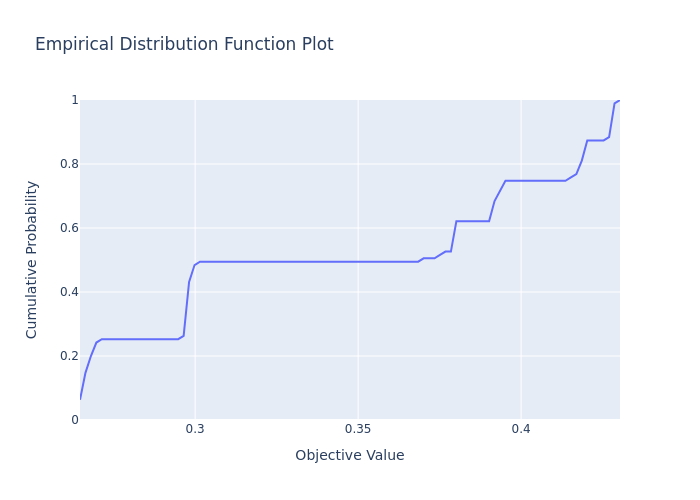

In [14]:
plot_edf(study)

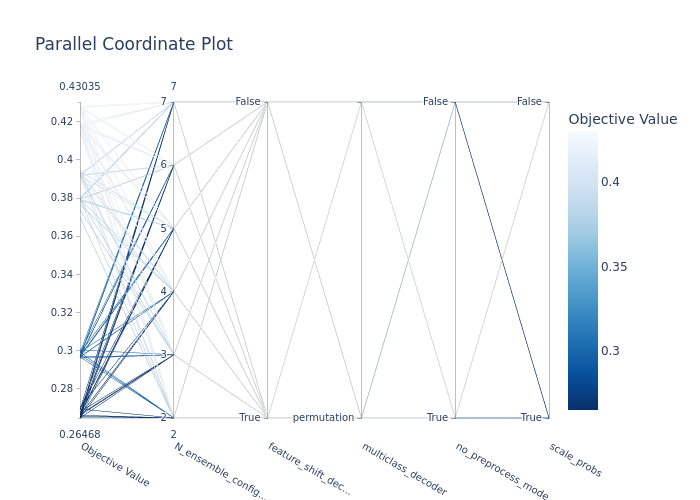

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
best_params["N_ensemble_configurations"] = 2**best_params.pop("N_ensemble_configurations_exp")
best_params

{'feature_shift_decoder': False,
 'multiclass_decoder': 'permutation',
 'no_preprocess_mode': False,
 'scale_probs': True,
 'N_ensemble_configurations': 8}

***